# 等距映射(Isometric Mapping, ISOMAP)

## 符号定义

|符号|含义|
|:-:|:-:|
|$\bm{x}$|样本点|
|$N$|总样本数|
|$W$|邻接矩阵|
|$Y$|降维后坐标构成的矩阵|
|$\bm{y}$|样本点降维后坐标|


## 概念

ISOMAP在MDS的基础上发展而来。最为原始的MDS采用欧氏距离计算两点间的距离。欧式距离是欧氏空间中两点间的直线距离，但是对于MDS这类流形降维方法，通常假设数据是低维流形镶嵌在高维空间中的结果，因此使用欧式距离直接计算两点之间的距离略为不妥。

在MDS的基础上，将距离度量方式由欧氏距离换为测地线或许是更好的选择，即在降维过程中不再是保持两点间的直线距离不变，而是保持两点间的“测地线距离”不变。由此提出ISOMAP算法。

ISOMAP中，使用**近似**测地线代替欧式距离对两点之间的距离进行度量。之所以称之为**近似**测地线，是因为对于由数据点构成的数据集来说，测地线无法直接得到。在ISOMAP算法中，实际采用的是**最短路径距离**。ISOMAP中会给每一个数据点定义一个邻域，邻域内的点采用欧式距离，而邻域外的点采用最短路径距离。得到两两数据点之间的距离后，使用类似于MDS中使用的优化方法即可得到降维后的结果。

显然ISOMAP包含三个重要步骤：
* 定义每一个数据点的邻域
* 在原空间中计算两两数据点之间的距离；
* 在低维空间中寻找一个集合，这个集合中任意两点之间的距离与其相对应的高维空间中的距离尽可能相同。

类似于MDS，上述第一、二步为“关系”的定义；第三步是一个优化问题。

## 推导

ISOMAP和MDS最大的不同是距离的计算，其余步骤则可以完全沿用[MDS的推导](../05_MDS/MDS.ipynb)。

对于最短路径距离的计算，这里采用Floyd算法，Floyd算法的详细分析有相当多的资料。

## 算法流程

* 设置最近邻点数k，并计算得到邻接矩阵
* 利用Floyd算法，计算两两点之间的最短路径距离
* 类似于MDS算法，计算内积矩阵$Y^TY$
* 对$Y^TY$进行特征分解得到前z个最大特征值以及其对应的特征向量，计算得到降维后的结果

## 参考资料

https://zhuanlan.zhihu.com/p/52591878

https://zhuanlan.zhihu.com/p/139112162

https://blog.csdn.net/zhangweiguo_717/article/details/69802312

In [1]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
from sklearn import manifold
from sklearn.decomposition import KernelPCA
from sklearn.utils.extmath import svd_flip
from sklearn.utils.graph import graph_shortest_path
from sklearn.neighbors import NearestNeighbors

In [2]:
class MyISOMAP(object):

    def __init__(self, input_data, reduction_dims, n_neighbors):

        self.input_data = input_data
        self.reduction_dims = reduction_dims
        self.n_neighbors = n_neighbors

        self.samples_num, self.input_dims = self.input_data.shape

        # distance mat
        self.distance_mat = np.ones((self.samples_num, self.samples_num)) * np.inf

        # reduction result
        self.output_mat = np.zeros((self.samples_num, reduction_dims))

    def __call__(self):
        self._cal_distance_mat()
        inner_product = self._cal_inner_product()
        topk_vals, topk_vecs = self._cal_topk_eigh(inner_product, self.reduction_dims)
        topk_vecs, _ = svd_flip(topk_vecs, np.zeros_like(topk_vecs).T)
        self.output_mat = np.matmul(topk_vecs, np.diag(np.power(topk_vals, 0.5).reshape(-1)))

        # --------------------- kernel pca ------------------------------
        # self._cal_distance_mat()
        # kernel_pca_ = KernelPCA(n_components=self.n_neighbors, kernel="precomputed")
        # G = self.distance_mat ** 2
        # G *= -0.5
        # self.output_mat = kernel_pca_.fit_transform(G)

        return self.output_mat

    def _cal_distance_mat(self):
        nbrs = NearestNeighbors(n_neighbors=self.n_neighbors+1).fit(self.input_data)
        knn_mask = nbrs.kneighbors_graph(self.input_data).toarray()

        # cal adjacency_mat
        self._cal_adjacency_mat(knn_mask)
        self._floyd()
    
    def _cal_adjacency_mat(self, mask_mat):
        position_list = np.argwhere(mask_mat == 1)
        for pos_ in position_list:
            self.distance_mat[pos_[0], pos_[1]] = np.power(np.sum(np.power(self.input_data[pos_[0], :]-self.input_data[pos_[1], :], 2)), 0.5)

    def _floyd(self):
        self.distance_mat = graph_shortest_path(self.distance_mat, method="FW", directed=False)

    def _cal_inner_product(self):
        distance_mat_squre = np.power(self.distance_mat, 2)

        # row sum
        distance_mat_row_sum = np.repeat(np.sum(distance_mat_squre, axis=0).reshape(-1, 1), self.samples_num, axis=1)

        # cul sum
        distance_mat_cul_sum = np.repeat(np.sum(distance_mat_squre, axis=1).reshape(1, -1), self.samples_num, axis=0)
        
        # total sum
        distance_mat_total_sum = np.ones((self.samples_num, self.samples_num)) * np.sum(distance_mat_squre)

        # cal inner product
        inner_product = -(distance_mat_squre - (distance_mat_row_sum + distance_mat_cul_sum)/self.samples_num + distance_mat_total_sum/pow(self.samples_num, 2))/2

        return inner_product

    def _cal_topk_eigh(self, mat, k):
        e_vals, e_vecs = np.linalg.eig(mat)
        sorted_ind = np.argsort(e_vals)

        topk_e_vals = e_vals[sorted_ind[:-1-k:-1]]
        topk_e_vecs = e_vecs[:, sorted_ind[:-1-k:-1]]
        return topk_e_vals, topk_e_vecs

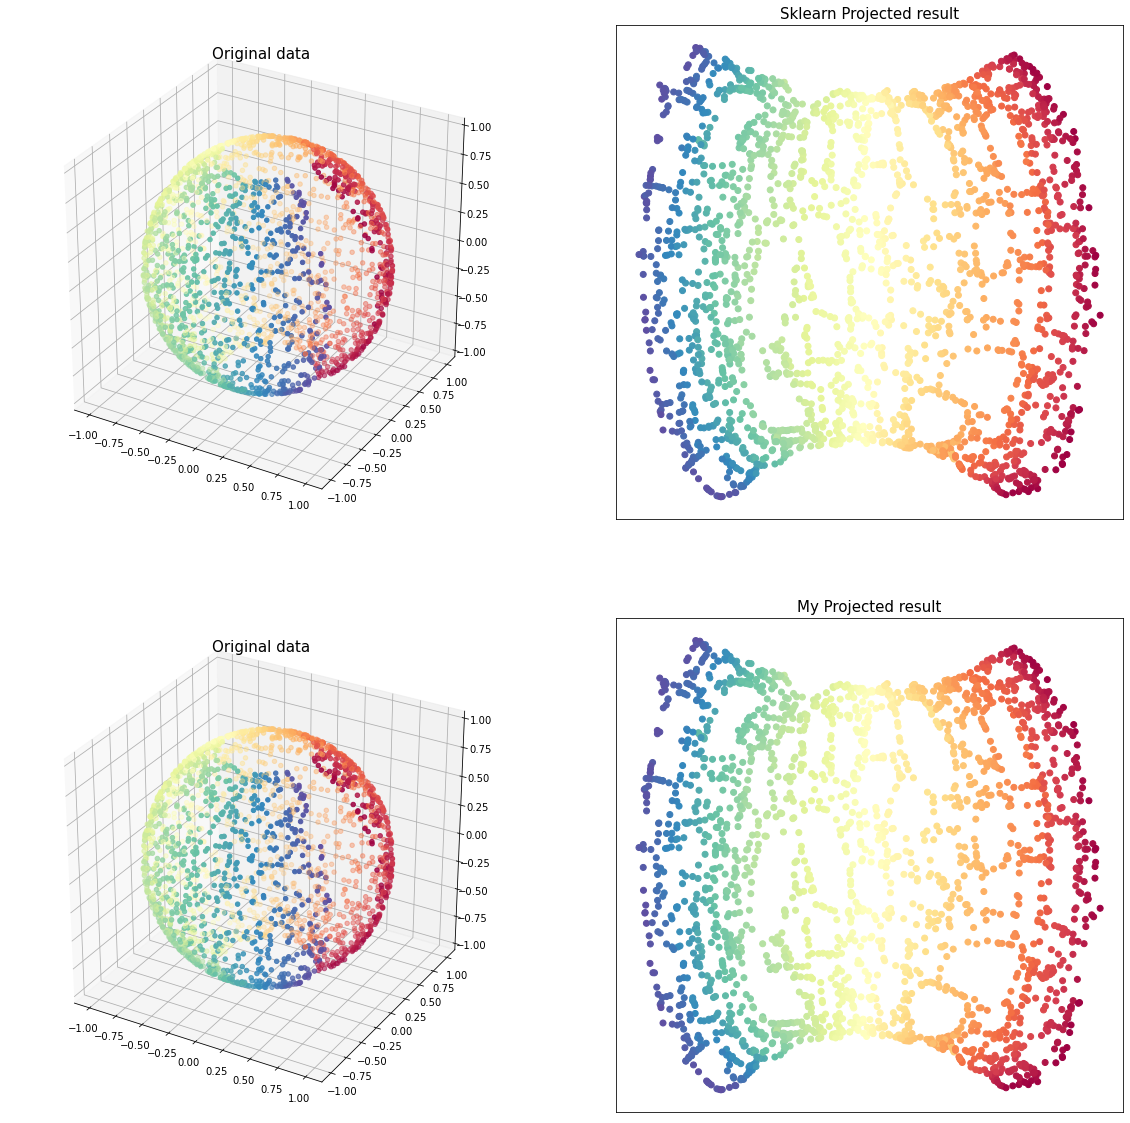

In [3]:
# ---------------------- create data ----------------------
n_samples = 3000

# Create our sphere.
np.random.seed(1024)
p = np.random.rand(n_samples) * (2 * np.pi - 0.55)
t = np.random.rand(n_samples) * np.pi

# Sever the poles from the sphere.
indices = (t < (np.pi - (np.pi / 8))) & (t > ((np.pi / 8)))
samples_color = p[indices]
x, y, z = (
    np.sin(t[indices]) * np.cos(p[indices]),
    np.sin(t[indices]) * np.sin(p[indices]),
    np.cos(t[indices]),
)
raw_samples = np.array([x, y, z]).T

# ---------------------- sklearn ISOMAP ---------------------- 
sklearn_isomap = manifold.Isomap(n_neighbors=5, n_components=2)
sklearn_isomap_result = sklearn_isomap.fit_transform(raw_samples)

# ---------------------- My ISOMAP ---------------------------
my_isomap = MyISOMAP(input_data=raw_samples, reduction_dims=2, n_neighbors=5)
my_isomap_result = my_isomap()

# ----------------------
# draw func
fig = plt.figure(figsize=(20, 20))

ax = fig.add_subplot(221, projection="3d")
ax.set_title("Training Data", fontsize=15)
ax.scatter(raw_samples[:, 0], raw_samples[:, 1], raw_samples[:, 2], c=samples_color, cmap=plt.cm.Spectral)

ax = fig.add_subplot(222)
plt.xticks([])
plt.yticks([])
plt.title("Projection of training data using sklearn ISOMAP", fontsize=15)
ax.scatter(sklearn_isomap_result[:, 0], sklearn_isomap_result[:, 1], c=samples_color, cmap=plt.cm.Spectral)

ax = fig.add_subplot(223, projection="3d")
ax.set_title("Training Data", fontsize=15)
ax.scatter(raw_samples[:, 0], raw_samples[:, 1], raw_samples[:, 2], c=samples_color, cmap=plt.cm.Spectral)

ax = fig.add_subplot(224)
plt.xticks([])
plt.yticks([])
plt.title("Projection of training data using My ISOMAP", fontsize=15)
ax.scatter(my_isomap_result[:, 0], my_isomap_result[:, 1], c=samples_color, cmap=plt.cm.Spectral)

plt.show()